In [1]:
import os
os.chdir('../')

In [2]:
# dcgan_reproduction/train.py
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader
from models import Generator, Discriminator

In [3]:
data_root = "./data"
output_dir = "./results/MINST/"
os.makedirs(output_dir, exist_ok=True)

image_size = 64
batch_size = 128
nz = 100             # Latent vector size
gf_dim = 64          # Generator feature maps
df_dim = 64          # Discriminator feature maps
nc = 1               # Number of channels (1 for grayscale MNIST)
epochs = 25
lr = 0.0002
beta1 = 0.5
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [4]:
dataset = dset.MNIST(root=data_root, download=True,
                     transform=transforms.Compose([
                         transforms.Resize(image_size),
                         transforms.ToTensor(),
                         transforms.Normalize((0.5,), (0.5,))]))

dataloader = DataLoader(dataset, batch_size=batch_size,
                        shuffle=True, num_workers=2)

In [5]:
netG = Generator.Generator(nz, gf_dim, nc).to(device)
netD = Discriminator.Discriminator(nc, df_dim).to(device)

netG.apply(lambda m: nn.init.normal_(m.weight.data, 0.0, 0.02) if isinstance(m, (nn.ConvTranspose2d, nn.BatchNorm2d)) else None)
netD.apply(lambda m: nn.init.normal_(m.weight.data, 0.0, 0.02) if isinstance(m, (nn.Conv2d, nn.BatchNorm2d)) else None)

# ─── LOSS AND OPTIMIZER ───────────────────────────────────────────────────────
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

fixed_noise = torch.randn(64, nz, 1, 1, device=device)

In [6]:
print("Starting Training Loop...")
for epoch in range(epochs):
    for i, (real_images, _) in enumerate(dataloader):
        # Update Discriminator
        netD.zero_grad()
        real_images = real_images.to(device)
        b_size = real_images.size(0)
        labels_real = torch.full((b_size,), 1., dtype=torch.float, device=device)
        output = netD(real_images).view(-1)
        errD_real = criterion(output, labels_real)

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake_images = netG(noise)
        labels_fake = torch.full((b_size,), 0., dtype=torch.float, device=device)
        output = netD(fake_images.detach()).view(-1)
        errD_fake = criterion(output, labels_fake)

        errD = errD_real + errD_fake
        errD.backward()
        optimizerD.step()

        # Update Generator
        netG.zero_grad()
        labels_gen = torch.full((b_size,), 1., dtype=torch.float, device=device)
        output = netD(fake_images).view(-1)
        errG = criterion(output, labels_gen)
        errG.backward()
        optimizerG.step()

        if i % 100 == 0:
            print(f"[{epoch}/{epochs}][{i}/{len(dataloader)}] Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f}")

    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
        vutils.save_image(fake, f"{output_dir}/fake_samples_epoch_{epoch:03d}.png", normalize=True)

print("Training Complete!")

Starting Training Loop...
[0/25][0/469] Loss_D: 1.3910 Loss_G: 0.7076
[0/25][100/469] Loss_D: 0.0255 Loss_G: 4.2928
[0/25][200/469] Loss_D: 0.0069 Loss_G: 5.5793
[0/25][300/469] Loss_D: 0.0032 Loss_G: 6.3991
[0/25][400/469] Loss_D: 1.1411 Loss_G: 1.6604
[1/25][0/469] Loss_D: 2.4441 Loss_G: 3.3817
[1/25][100/469] Loss_D: 0.6220 Loss_G: 1.4447
[1/25][200/469] Loss_D: 0.9766 Loss_G: 3.2113
[1/25][300/469] Loss_D: 0.6480 Loss_G: 2.2867
[1/25][400/469] Loss_D: 0.7916 Loss_G: 1.0948
[2/25][0/469] Loss_D: 0.6578 Loss_G: 1.5846
[2/25][100/469] Loss_D: 0.8899 Loss_G: 1.3300
[2/25][200/469] Loss_D: 0.7912 Loss_G: 1.3941
[2/25][300/469] Loss_D: 0.7101 Loss_G: 1.1326
[2/25][400/469] Loss_D: 0.8385 Loss_G: 0.7545
[3/25][0/469] Loss_D: 0.7196 Loss_G: 2.4997
[3/25][100/469] Loss_D: 0.8434 Loss_G: 1.4746
[3/25][200/469] Loss_D: 0.7805 Loss_G: 3.7110
[3/25][300/469] Loss_D: 0.5411 Loss_G: 1.7637
[3/25][400/469] Loss_D: 0.9984 Loss_G: 0.4302
[4/25][0/469] Loss_D: 0.7207 Loss_G: 1.6145
[4/25][100/469] Lo

# Final Results

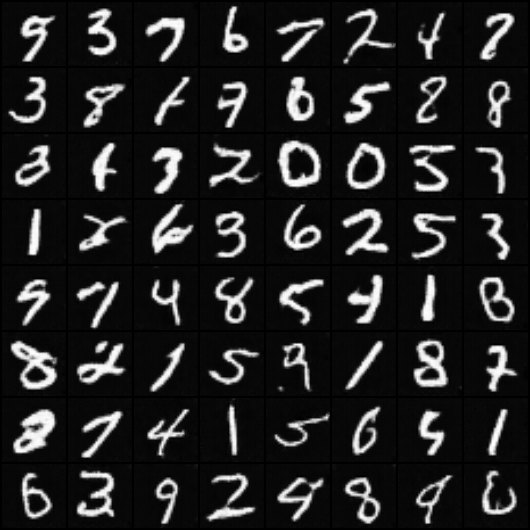